In [1]:
%matplotlib inline

import warnings
import time
import datetime
import sys
import numpy as np

from matplotlib import cm, pyplot as plt
import matplotlib.dates as dates
from hmmlearn import hmm

import random
import pandas as pd
from scipy import stats
from sklearn import preprocessing

pd.options.mode.use_inf_as_na = True
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
csv_data = pd.read_csv('SP500.csv')

date_list = pd.to_datetime(csv_data['Date'])
volume_list = csv_data['Volume']
open_list = csv_data['Volume']
close_list = csv_data['Close']

In [3]:
logDel = (np.log(np.array(csv_data['High'])) - np.log(np.array(csv_data['Low'])))[5:]
logRet_1 = np.array(np.diff(np.log(close_list)))[4:]
logRet_5 = np.log(np.array(close_list[5:])) - np.log(np.array(close_list[:-5]))
logVol_5 = np.log(np.array(volume_list[5:])) - np.log(np.array(volume_list[:-5]))

In [4]:
date_list = date_list[5:]
volume_list = volume_list[5:]
open_list = open_list[5:]
close_list = close_list[5:]

del(csv_data['Date'])
del(csv_data['Adj Close'])
del(csv_data['Volume'])

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


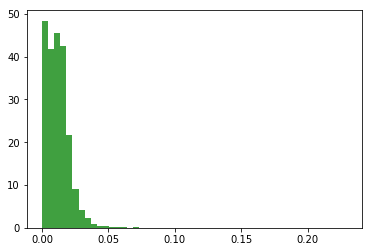

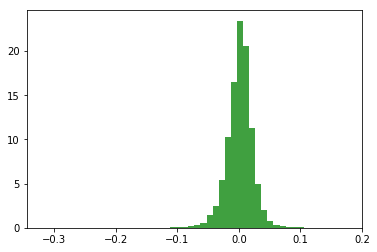

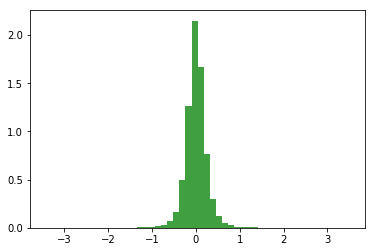

In [5]:
n, bins, patches = plt.hist(logDel, 50, normed=1, facecolor='green', alpha=0.75)
plt.show()
n, bins, patches = plt.hist(logRet_5, 50, normed=1, facecolor='green', alpha=0.75)
plt.show()
n, bins, patches = plt.hist(logVol_5, 50, normed=1, facecolor='green', alpha=0.75)
plt.show()

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


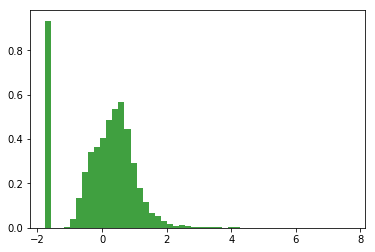

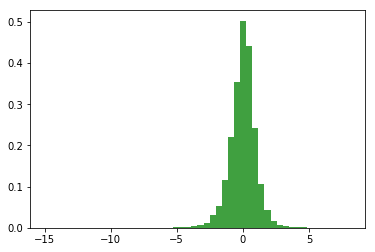

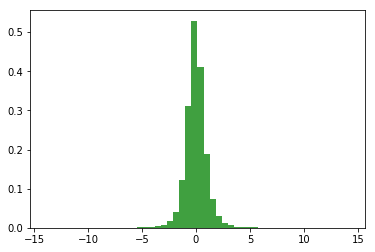

In [6]:
# 没有这个东西stas.boxcox会出错
logDel[logDel == 0] = 0.0001

# Box-Cox Transformation of the observation sequences

boxcox_logDel, _ = stats.boxcox(logDel)

# Standardize the observation sequence distribution

rescaled_boxcox_logDel = preprocessing.scale(boxcox_logDel, axis=0, with_mean=True, with_std=True, copy=False)

rescaled_logRet_5 = preprocessing.scale(logRet_5, axis=0, with_mean=True, with_std=True, copy=False)

rescaled_logVol_5 = preprocessing.scale(logVol_5, axis=0, with_mean=True, with_std=True, copy=False)

# the histogram of the rescaled observation sequences

n, bins, patches = plt.hist(rescaled_boxcox_logDel, 50, normed=1, facecolor='green', alpha=0.75)

plt.show()

n, bins, patches = plt.hist(rescaled_logRet_5, 50, normed=1, facecolor='green', alpha=0.75)

plt.show()

n, bins, patches = plt.hist(rescaled_logVol_5, 50, normed=1, facecolor='green', alpha=0.75)

plt.show()

In [7]:
# Observation sequences matrix 
A = np.column_stack([logDel,logRet_5,logVol_5]) 

# Rescaled observation sequences matrix 
rescaled_A = np.column_stack([rescaled_boxcox_logDel, rescaled_logRet_5, rescaled_logVol_5]) 

In [37]:
NUM_TEST = 100
NUM_ITERS=100
DEFAULT_TOL = 1e-12
STATES = 10

model = hmm.GaussianHMM(n_components=STATES, covariance_type='full', tol=DEFAULT_TOL, n_iter=NUM_ITERS)
model.fit(A)

hidden_states = model.predict(A)
hidden_states

array([5, 5, 5, ..., 9, 9, 9])

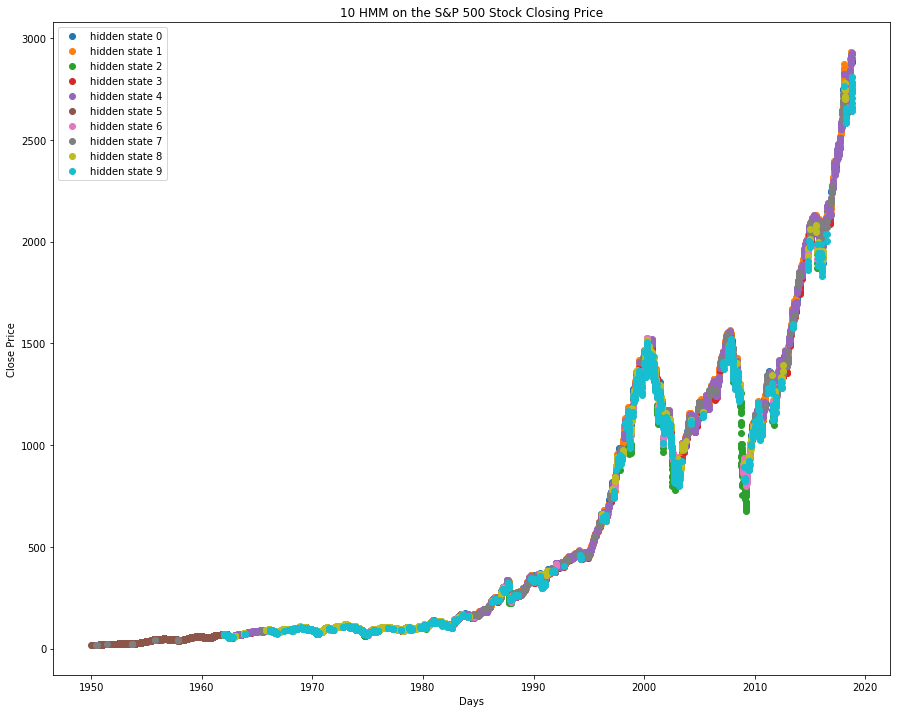

In [38]:
# Plot the hidden states
plt.figure(figsize=(15, 12))
plt.title("10 HMM on the S&P 500 Stock Closing Price")
plt.xlabel("Days")
plt.ylabel("Close Price")
for i in range(model.n_components):
    pos = (hidden_states==i)
    plt.plot_date(date_list[pos],close_list[pos],'o',label='hidden state %d'%i,lw=2)
    plt.legend(loc="upper left")

In [39]:
NUM_TEST = 100
NUM_ITERS=100
DEFAULT_TOL = 1e-12
STATES = 3

model = hmm.GaussianHMM(n_components=STATES, covariance_type='full', tol=DEFAULT_TOL, n_iter=NUM_ITERS)
model.fit(A)

hidden_states = model.predict(A)
hidden_states

array([1, 1, 1, ..., 0, 0, 0])

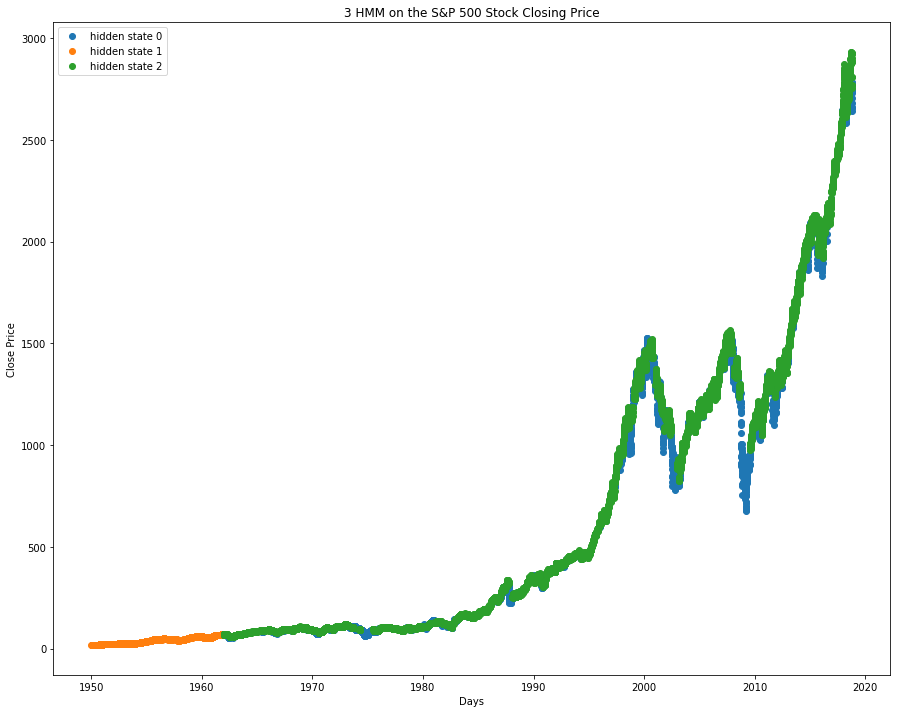

In [40]:
# Plot the hidden states
plt.figure(figsize=(15, 12))
plt.title("3 HMM on the S&P 500 Stock Closing Price")
plt.xlabel("Days")
plt.ylabel("Close Price")
for i in range(model.n_components):
    pos = (hidden_states==i)
    plt.plot_date(date_list[pos],close_list[pos],'o',label='hidden state %d'%i,lw=2)
    plt.legend(loc="upper left")

In [10]:
# HMM modeling based on processed observation sequences
rescaled_model = hmm.GaussianHMM(n_components=STATES, covariance_type='full', tol=DEFAULT_TOL, n_iter=NUM_ITERS)
rescaled_model.fit(rescaled_A)
rescaled_hidden_states = rescaled_model.predict(rescaled_A)
rescaled_hidden_states

array([2, 2, 2, ..., 0, 0, 0])

/usr/local/lib/python3.6/site-packages/matplotlib/legend.py:641: UserWarning: Unrecognized location "left". Falling back on "best"; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center

  % (loc, '\n\t'.join(self.codes)))


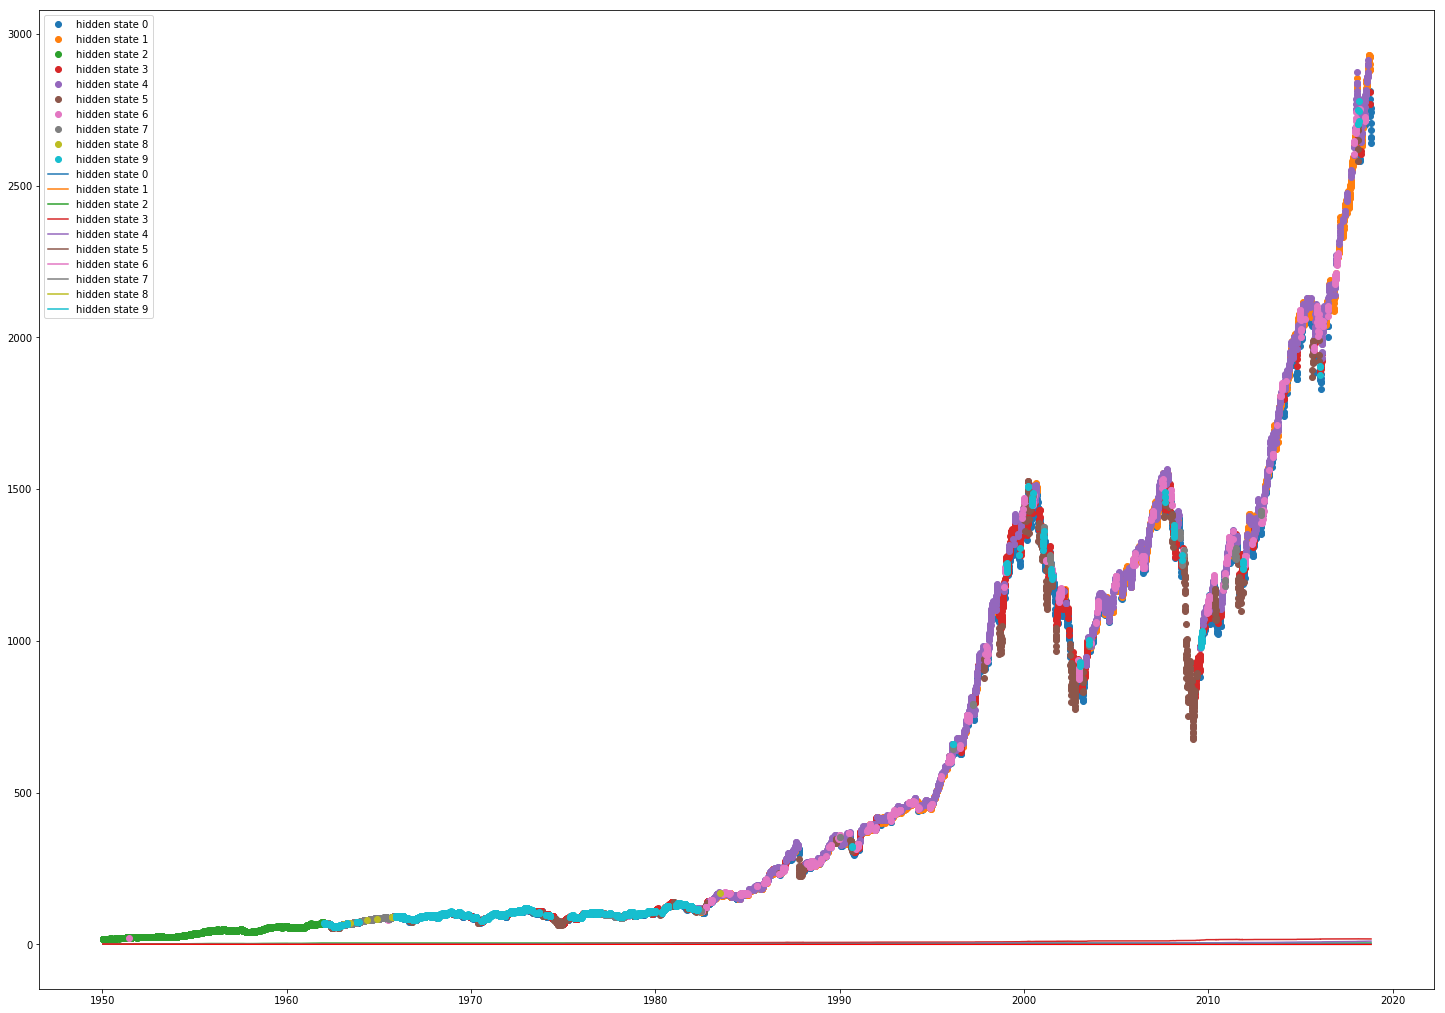

In [12]:
# Plot the hidden states
plt.figure(figsize=(25, 18)) 
for i in range(model.n_components):
    pos = (rescaled_hidden_states==i)
    plt.plot_date(date_list[pos],close_list[pos],'o',label='hidden state %d'%i,lw=2)
    plt.legend(loc="left")

# Trading test according to the hidden states
for i in range(STATES):
    pos = (rescaled_hidden_states==i)
    pos = np.append(0,pos[:-1])#第二天进行买入操作
    df = logRet_1
    res['state_ret%s'%i] = df * pos
    plt.plot_date(date_list,np.exp(res['state_ret%s'%i].cumsum()),'-',label='hidden state %d'%i)
    plt.legend(loc="left")

# Trading test2 according to the hidden states
long = (rescaled_hidden_states==0)  #做多
short = (rescaled_hidden_states==1) + (rescaled_hidden_states == 2)  #做空
long = np.append(0,long[:-1]) #第二天才能操作
short = np.append(0,short[:-1]) #第二天才能操作

# Yield Curve
res['ret'] =  df * long - df * short
plt.plot_date(date_list,np.exp(res['ret'].cumsum()),'r-')